In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import chain
from skimage.io import imread, imshow


##Import any other packages you may need here

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation

DATAPATH = '/home/danielchan/Chest_Xray_Data/'

all_xray_df = pd.read_csv(DATAPATH+'Data_Entry_2017.csv')
all_xray_df.sample(3)

#data_sample = pd.read_csv('sample_labels.csv')
#data_sample.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
99060,00026199_006.png,Infiltration,6,26199,46,M,AP,3056,2544,0.139,0.139,NaN
74724,00018356_009.png,No Finding,9,18356,49,M,PA,2992,2991,0.143,0.143,NaN
88753,00021994_000.png,No Finding,0,21994,51,F,AP,3056,2544,0.139,0.139,NaN


**find the number of unique patients**

In [3]:
print ( "Number of Unique Patients: ", len(np.unique( all_xray_df['Patient ID'].values ) ) )

Number of Unique Patients:  30805


In [4]:
#data_sample['Patient Age'] = data_sample['Patient Age'].map(lambda x: str(x)[:-1]).astype(int)

**Let's look the demographic dsitribution for age and gender**

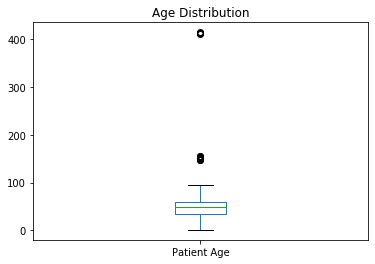

In [5]:
all_xray_df['Patient Age'].plot(kind='box',title='Age Distribution')

**There are some outliners in the data (highly unlikely to have a 414 years old person), we will narrow the age group to 1 standard deviation from the mean**

In [6]:
all_xray_df['Patient Age'].describe()

count    112120.000000
mean         46.901463
std          16.839923
min           1.000000
25%          35.000000
50%          49.000000
75%          59.000000
max         414.000000
Name: Patient Age, dtype: float64

In [7]:
factor = 1.0
pMean = all_xray_df['Patient Age'].mean()
pstd  = all_xray_df['Patient Age'].std()
pAgeLower = int(pMean - factor*pstd)
pAgeUpper = int(pMean + factor*pstd)

print ("Lower and Upper Bound for Age:",pAgeLower, pAgeUpper)

Lower and Upper Bound for Age: 30 63


In [8]:
filtered = all_xray_df[ (all_xray_df['Patient Age'] >= pAgeLower) &  
                        (all_xray_df['Patient Age'] <= pAgeUpper)  ]

In [9]:
print ( filtered.shape[0]/all_xray_df.shape[0]*100, "% of the data set" )

66.34944702104887 % of the data set


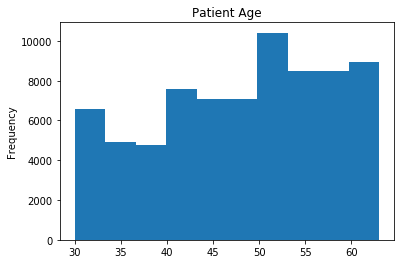

In [10]:
filtered['Patient Age'].plot(kind='hist',title='Patient Age')

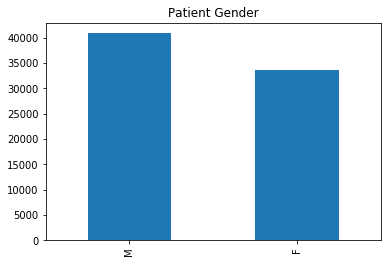

In [11]:
filtered['Patient Gender'].value_counts().plot(kind='bar',title='Patient Gender')

In [12]:
filtered['Patient Gender'].value_counts()

M    40879
F    33512
Name: Patient Gender, dtype: int64

In [13]:
# remove the original dataframe to preserve memory
del all_xray_df

**Both age and gender distributions look good, i.e. it is balanced**

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

### Extract training data set for Pneumonia

In [14]:
all_labels = np.unique(list(chain(*filtered['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        filtered[c_label] = filtered['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
filtered.sample(5)


All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
7974,00002084_000.png,Cardiomegaly,0,2084,51,M,PA,2830,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
67352,00016630_005.png,No Finding,5,16630,30,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
45452,00011654_001.png,Mass,1,11654,44,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
29661,00007719_000.png,No Finding,0,7719,59,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
55774,00013957_000.png,No Finding,0,13957,63,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [15]:
len(all_labels)

15

**Let's find out more about No Finding, Number of Pneumonia Cases, Unique Patient IDs and View Positions**

In [16]:
filtered['No Finding'].value_counts()

1.0    40376
0.0    34015
Name: No Finding, dtype: int64

In [17]:
filtered['Pneumonia'].value_counts()

0.0    73499
1.0      892
Name: Pneumonia, dtype: int64

In [18]:
filtered[ filtered['Pneumonia']==1]['View Position'].value_counts()

AP    489
PA    403
Name: View Position, dtype: int64

In [19]:
# number of unique patients with Pneumonia
len (np.unique( filtered[ filtered['Pneumonia']==1]['Patient ID'].values ))

644

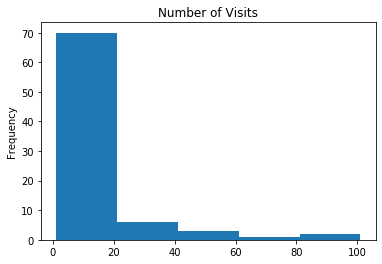

In [20]:
# look at how many repeat visits are there
filtered[ filtered['Pneumonia']==1]['Follow-up #'].value_counts().plot(kind='hist',bins=5,title="Number of Visits")

In [21]:
filtered[ filtered['Pneumonia']==1]['Follow-up #'].value_counts().describe()

count     82.000000
mean      10.878049
std       18.867563
min        1.000000
25%        1.000000
50%        3.000000
75%        9.750000
max      101.000000
Name: Follow-up #, dtype: float64

**75% of positive Pneumonia cases have less than 10 visits**

### Let's look at the age distribution for different diseases

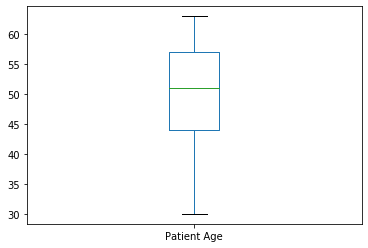

In [22]:
# for Atelectasis

filtered[filtered['Atelectasis']==1]['Patient Age'].plot(kind='box')

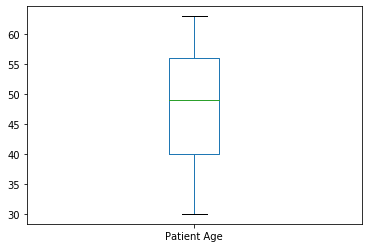

In [23]:
# for Edema

filtered[filtered['Edema']==1]['Patient Age'].plot(kind='box')

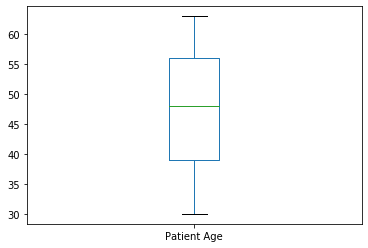

In [24]:
# for Pneumonia

filtered[filtered['Pneumonia']==1]['Patient Age'].plot(kind='box')

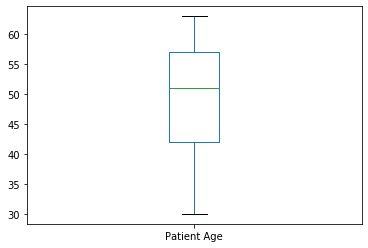

In [25]:
# for Effusion

filtered[filtered['Effusion']==1]['Patient Age'].plot(kind='box')

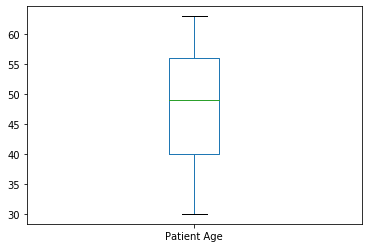

In [26]:
# for Infiltration

filtered[filtered['Infiltration']==1]['Patient Age'].plot(kind='box')

In [27]:
filtered[ (filtered['Pneumonia']==1)    &
          ( (filtered['Infiltration']==1) |
            (filtered['Effusion']==1)     |
            (filtered['Edema']==1 )       |
            (filtered['Atelectasis']==1) )]['Follow-up #'].value_counts().describe()

count    76.000000
mean      8.131579
std      12.179044
min       1.000000
25%       1.000000
50%       2.500000
75%       8.000000
max      54.000000
Name: Follow-up #, dtype: float64

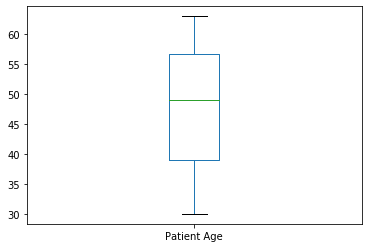

In [28]:
# Age distribution for those who have Pneumonia and one other disease

filtered[ (filtered['Pneumonia']==1)    &
          ( (filtered['Infiltration']==1) |
            (filtered['Effusion']==1)     |
            (filtered['Edema']==1 )       |
            (filtered['Atelectasis']==1) )]['Patient Age'].plot(kind='box')

In [29]:
filtered[   (filtered['Infiltration']==1)   |
            (filtered['Effusion']==1)       |
            (filtered['Edema']==1 )         |
            (filtered['Atelectasis']==1)       ]['Pneumonia'].value_counts()

0.0    23361
1.0      618
Name: Pneumonia, dtype: int64

# Describe how to set up the model training based on the findings

In [30]:
## frequency of co-occurence with other diseases

for d in all_labels:
    print ( d," ",filtered [ (filtered['Pneumonia']==1) & (filtered[d]==1)].shape[0]/892.*100. )

Atelectasis   20.291479820627803
Cardiomegaly   3.0269058295964126
Consolidation   9.865470852017937
Edema   24.2152466367713
Effusion   19.61883408071749
Emphysema   1.345291479820628
Fibrosis   1.0089686098654709
Hernia   0.336322869955157
Infiltration   40.246636771300444
Mass   5.493273542600897
No Finding   0.0
Nodule   5.493273542600897
Pleural_Thickening   3.4753363228699556
Pneumonia   100.0
Pneumothorax   3.4753363228699556


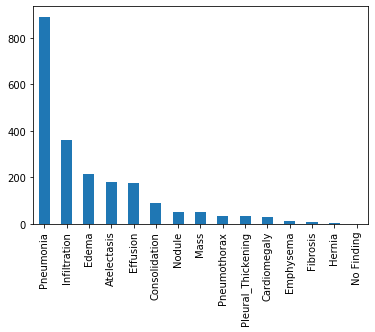

In [31]:
occur ={}
for d in all_labels:    
    #occur[d] = filtered [ (filtered['Pneumonia']==1) & (filtered[d]==1)].shape[0]/892.*100. 
    occur[d] = filtered [ (filtered['Pneumonia']==1) & (filtered[d]==1)].shape[0]

    
series = pd.Series(occur).sort_values(ascending=False)
series.plot(kind='bar')

**Top 4 most common comorbidities for Pneumonia are: Infiltration, Edema, Atelectasis​ and Effusion**

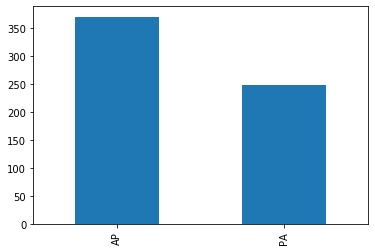

In [32]:
filtered[ (filtered['Pneumonia']==1)    &
          ( (filtered['Infiltration']==1) |
            (filtered['Effusion']==1)     |
            (filtered['Edema']==1 )       |
            (filtered['Atelectasis']==1) )]['View Position'].value_counts().plot(kind='bar')

In [33]:
filtered[ (filtered['Pneumonia']==1)    &
          ( (filtered['Infiltration']==1) |
            (filtered['Effusion']==1)     |
            (filtered['Edema']==1 )       |
            (filtered['Atelectasis']==1) )]['View Position'].value_counts()

AP    370
PA    248
Name: View Position, dtype: int64

**There are 618 Pneumonia cases with at least one other comorbidity**

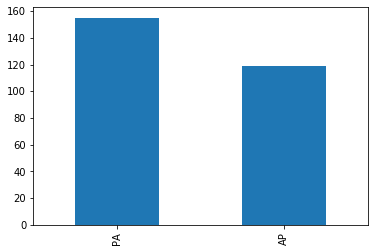

In [34]:
filtered[ (filtered['Pneumonia']==1)    &
          ( (filtered['Infiltration']==0) &
            (filtered['Effusion']==0)     &
            (filtered['Edema']==0 )       &
            (filtered['Atelectasis']==0) )]['View Position'].value_counts().plot(kind='bar')

In [35]:
filtered[ (filtered['Pneumonia']==1)    &
          ( (filtered['Infiltration']==0) &
            (filtered['Effusion']==0)     &
            (filtered['Edema']==0 )       &
            (filtered['Atelectasis']==0) )]['View Position'].value_counts()

PA    155
AP    119
Name: View Position, dtype: int64

**There are 274 Pneumonia ONLY cases and the PA view produces more positive cases than the AP view**

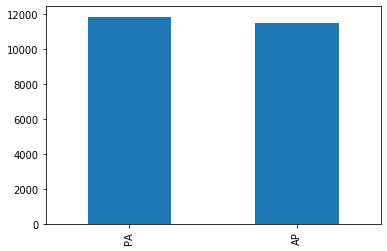

In [36]:
filtered[ (filtered['Pneumonia']==0)    &
          ( (filtered['Infiltration']==1) |
            (filtered['Effusion']==1)     |
            (filtered['Edema']==1 )       |
            (filtered['Atelectasis']==1) )]['View Position'].value_counts().plot(kind='bar')

In [37]:
filtered.head(5)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38,00000013_000.png,No Finding,0,13,61,M,PA,2021,2021,0.194311,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
39,00000013_001.png,Emphysema|Pneumothorax,1,13,60,M,AP,3056,2544,0.139000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [38]:

all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join(DATAPATH,'images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', filtered.shape[0])
filtered['path'] = filtered['Image Index'].map(all_image_paths.get)
filtered.sample(3)



Scans found: 112120 , Total Headers 74391


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,path
27212,00007089_000.png,No Finding,0,7089,58,F,AP,2500,2048,0.171,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,/home/danielchan/Chest_Xray_Data/images_004/im...
854,00000211_008.png,Cardiomegaly|Effusion,8,211,58,F,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/home/danielchan/Chest_Xray_Data/images_001/im...
57609,00014274_002.png,No Finding,2,14274,32,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,/home/danielchan/Chest_Xray_Data/images_007/im...


## Look at pixel intensitites for different diseases

In [39]:
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)
pd.options.display.max_colwidth = 100

# for Pneumonia

VIEW = "PA"

samp = filtered[(filtered['Pneumonia']==1 ) 
                # & (filtered['View Position']==VIEW)  
               ].sample(5)['path'].values

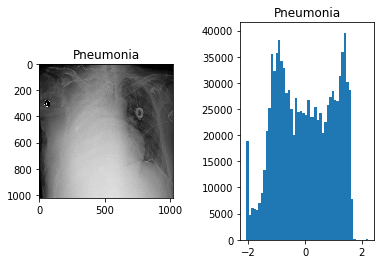

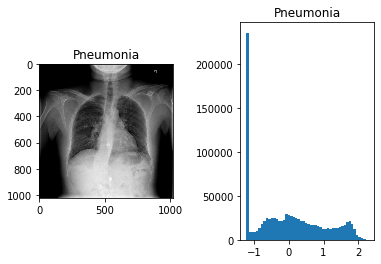

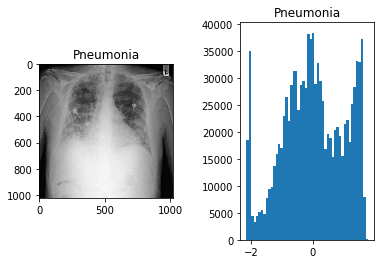

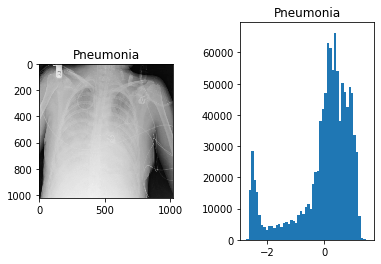

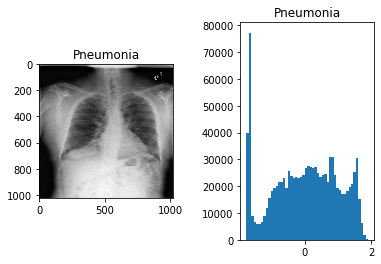

In [40]:
for img in samp:
    plt.subplot(1, 2, 1)
    pic = imread( img )
    plt.imshow(pic,cmap='gray')
    plt.title('Pneumonia')

    plt.subplot(1, 2, 2)
    pic = pic.ravel()
    pic = (pic - pic.mean())/pic.std()
    plt.hist(pic, bins=50,density=False)
    plt.title('Pneumonia')
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)

    plt.show()

#plt.figure(figsize=(5,5))
#plt.hist(dcm.pixel_array.ravel(), bins = 256)

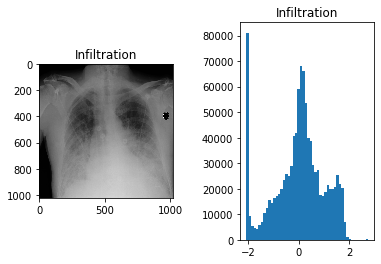

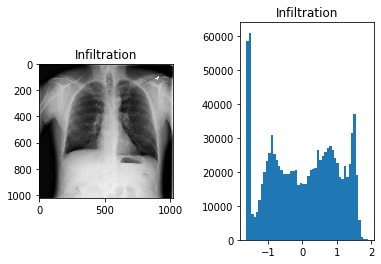

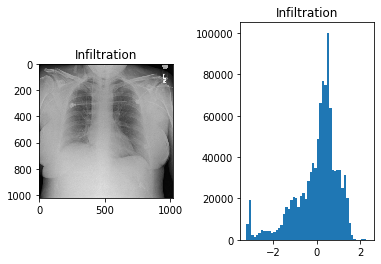

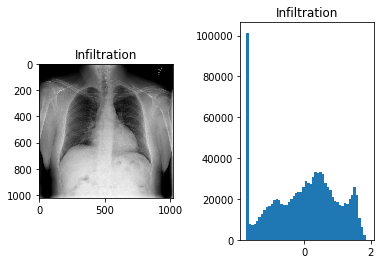

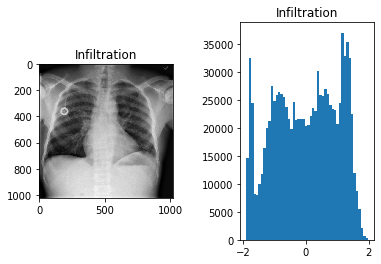

In [41]:
# for Infiltration

samp = filtered[(filtered['Infiltration']==1 ) 
                #  & (filtered['View Position']==VIEW)  
               
               ].sample(5)['path'].values

for img in samp:
    plt.subplot(1, 2, 1)
    pic = imread( img )
    plt.imshow(pic,cmap='gray')
    plt.title('Infiltration')

    plt.subplot(1, 2, 2)
    pic = pic.ravel()
    pic = (pic - pic.mean())/pic.std()
    plt.hist(pic, bins=50,density=False)
    plt.title('Infiltration')
    
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)

    plt.show()

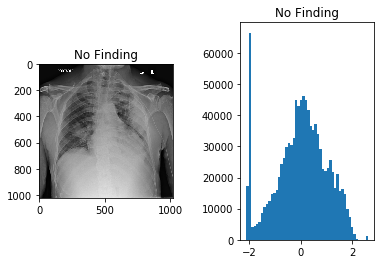

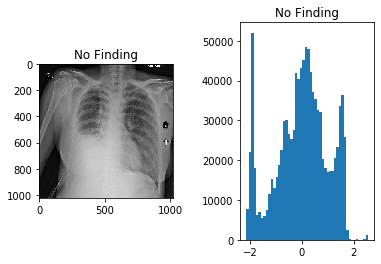

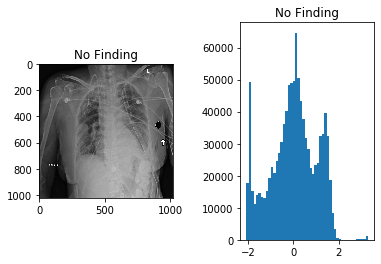

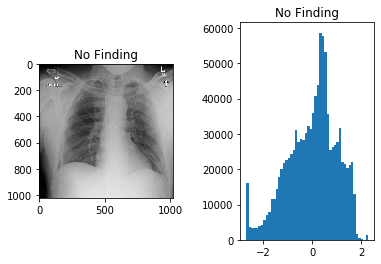

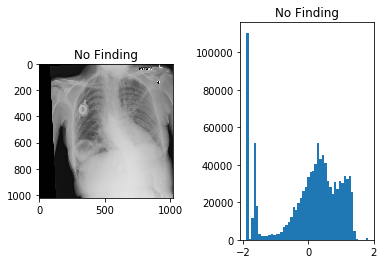

In [42]:
samp = filtered[ (filtered['No Finding']==0)  
#                  & (filtered['View Position']==VIEW)
               ].sample(5)['path'].values

for img in samp:
    plt.subplot(1, 2, 1)
    pic = imread( img )
    plt.imshow(pic,cmap='gray')
    plt.title('No Finding')

    plt.subplot(1, 2, 2)
    pic = pic.ravel()
    pic = (pic - pic.mean())/pic.std()
    plt.hist(pic, bins=50,density=False)
    plt.title('No Finding')
    
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)

    plt.show()

**Pneumonia and Infiltration cases show more white spots in the X-ray pictures but do not exhibit any particular trends in the pixel intensity histograms when comparing to those with no finding.**

In [43]:
# look at the possibility of removing the impact of other diseases

VIEW = "PA"
filteredPN = filtered[ (filtered['Pneumonia']==1)    &
            ((filtered['Infiltration']==0)          &
            (filtered['Effusion']==0)               &
            (filtered['Edema']==0 )                 &
            (filtered['Atelectasis']==0) )          &
            (filtered['View Position']==VIEW) ].sample(5)['path'].values
filteredNo = filtered[ (filtered['No Finding']==1)   &  
                       (filtered['View Position']==VIEW) ].sample(5)['path'].values



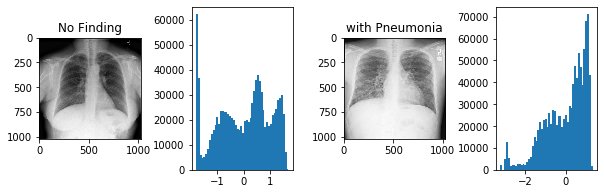

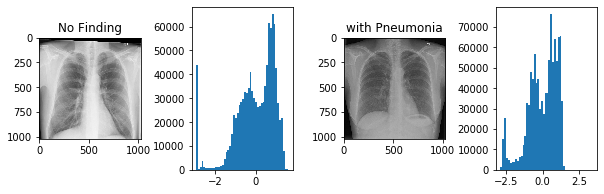

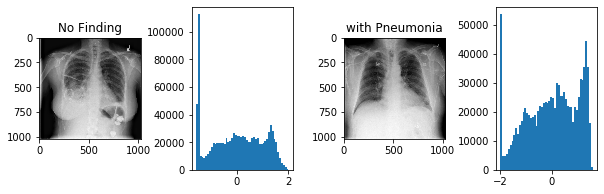

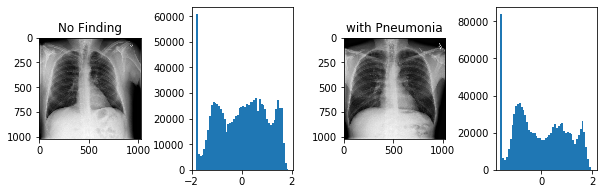

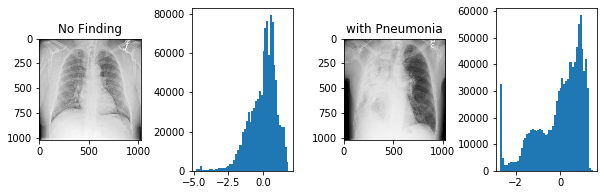

In [44]:

for img1, img2 in zip(filteredNo,filteredPN):
    plt.figure(figsize=(10.,3.))
    plt.subplot(1, 4, 1)
    pic = imread( img1 )
    plt.imshow(pic,cmap='gray')
    plt.title('No Finding')
    plt.subplot(1, 4, 2)
    pic = pic.ravel()
    pic = (pic - pic.mean())/pic.std()
    plt.hist(pic, bins=50,density=False)
    plt.ylim=(0, 0.1)
    plt.subplot(1, 4, 3)
    pic = imread( img2 )
    plt.imshow(pic,cmap='gray')
    plt.title('with Pneumonia')

    plt.subplot(1, 4, 4)
    pic = pic.ravel()
    pic = (pic - pic.mean())/pic.std()
    plt.hist(pic, bins=50,density=False)

    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)

    plt.show()

**Radiologists look for white spots in the X-ray picture of a lung to determine the presence of Pneumonia. These white spots are evident in the above pictures labelled with "with Pneumonia". When comparing the histogram between "No FInding" and Pneumonia, there are discernible differences, but not special trends that one can use to distinguish them. Therefore, we would need a more sophisticated method, such as CNN, to classify them.**

In [45]:
filteredD ={}
filteredD['Pneumonia'] = filtered[ (filtered['Pneumonia']==0)    &
            ((filtered['Infiltration']==1)          &
            (filtered['Effusion']==0)               &
            (filtered['Edema']==0 )                 &
            (filtered['Atelectasis']==0) )          &
            (filtered['View Position']=="AP") ].sample(5)['path'].values

In [46]:
filteredD

{'Pneumonia': array(['/home/danielchan/Chest_Xray_Data/images_005/images/00010828_010.png',
        '/home/danielchan/Chest_Xray_Data/images_002/images/00003610_008.png',
        '/home/danielchan/Chest_Xray_Data/images_006/images/00012328_002.png',
        '/home/danielchan/Chest_Xray_Data/images_003/images/00006271_050.png',
        '/home/danielchan/Chest_Xray_Data/images_011/images/00025849_052.png'],
       dtype=object)}

In [47]:
#VIEW = "AP"
VIEW = "PA"


filteredD['Pneumonia'] = filtered[ (filtered['Pneumonia']==1)    &
            ((filtered['Infiltration']==0)          &
            (filtered['Effusion']==0)               &
            (filtered['Edema']==0 )                 &
            (filtered['Atelectasis']==0) )          &
            (filtered['View Position']==VIEW)       &
            (filtered['Follow-up #'] >2 )       ].sample(5)['path'].values


filteredD['Infiltration'] = filtered[ (filtered['Pneumonia']==0)    &
            ((filtered['Infiltration']==1)          &
            (filtered['Effusion']==0)               &
            (filtered['Edema']==0 )                 &
            (filtered['Atelectasis']==0) )          &
            (filtered['View Position']==VIEW) ].sample(5)['path'].values

filteredD['Effusion'] = filtered[ (filtered['Pneumonia']==0)    &
            ((filtered['Infiltration']==0)          &
            (filtered['Effusion']==1)               &
            (filtered['Edema']==0 )                 &
            (filtered['Atelectasis']==0) )          &
            (filtered['View Position']==VIEW) ].sample(5)['path'].values

filteredD['Edema'] = filtered[ (filtered['Pneumonia']==0)    &
            ((filtered['Infiltration']==0)          &
            (filtered['Effusion']==0)               &
            (filtered['Edema']==1 )                 &
            (filtered['Atelectasis']==0) )          &
            (filtered['View Position']==VIEW) ].sample(5)['path'].values

filteredD['Atelectasis'] = filtered[ (filtered['Pneumonia']==0)    &
            ((filtered['Infiltration']==0)          &
            (filtered['Effusion']==0)               &
            (filtered['Edema']==0 )                 &
            (filtered['Atelectasis']==1) )          &
            (filtered['View Position']==VIEW) ].sample(5)['path'].values

filteredD['No Finding'] = filtered[ (filtered['No Finding']==1)   &  
                       (filtered['View Position']==VIEW) ].sample(5)['path'].values



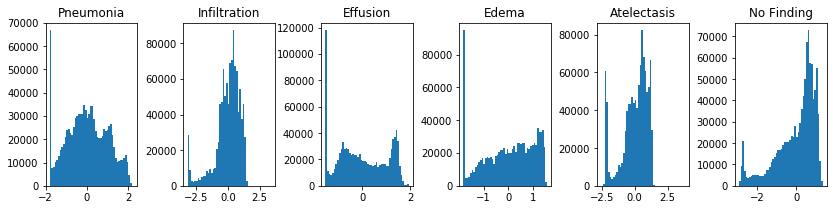

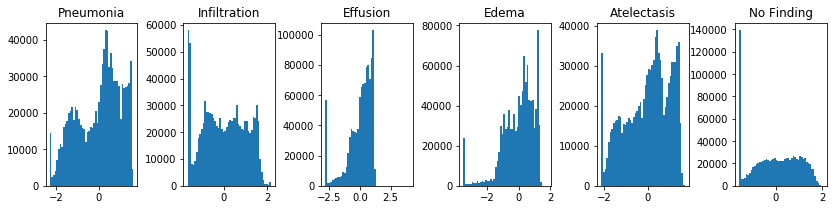

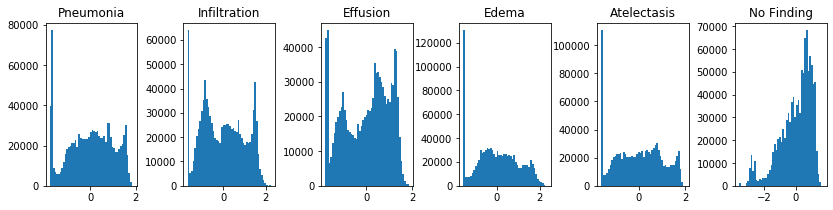

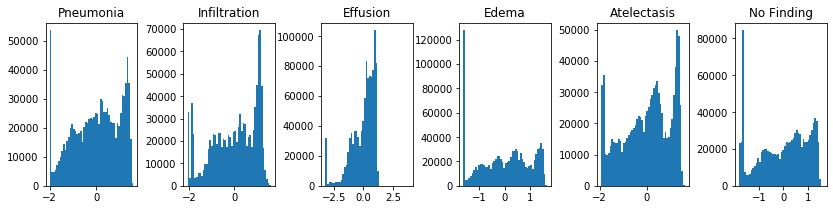

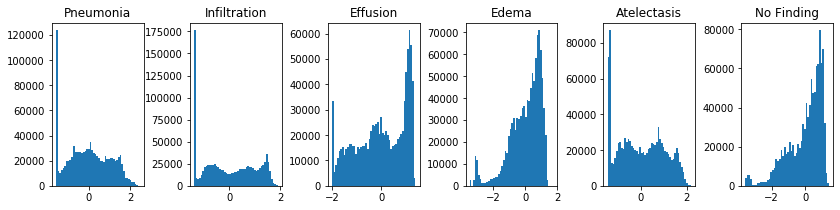

In [48]:
diseases = ['Pneumonia','Infiltration','Effusion','Edema','Atelectasis','No Finding']
for sample in range(5):
    plt.figure(figsize=(14.,3.))
    ip = 0
    for disease in diseases:
        plt.subplot(1, 6, ip+1)
        pic = imread( filteredD[disease][sample] )
        plt.title(disease)
        pic = pic.ravel()
        pic = (pic - pic.mean())/pic.std()
        plt.hist(pic, bins = 50,density=False)
        ip = ip +1
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)
    plt.show()

**Pixel intensities for comorbidities are very similar on the histogram, as our focus is on Pneumonia, we need to remove them from our training data set to achieve good accurracy.**

In [49]:
# all Pneumonia only cases


posCases=filtered[ (filtered['Pneumonia']==1)    &
            ((filtered['Infiltration']==0)          &
            (filtered['Effusion']==0)               &
            (filtered['Edema']==0 )                 &
            (filtered['Atelectasis']==0) )          &
            #(filtered['View Position']==VIEW)       &
            (filtered['Follow-up #'] >= 0 )       ]

In [50]:
posCases.shape

(274, 28)

In [51]:
negCases=filtered[ (filtered['No Finding']==1)    
            #(filtered['View Position']==VIEW)       
             & (filtered['Follow-up #'] >= 5 )       ]

In [52]:
negCases.shape

(12650, 28)

In [53]:
negCases = negCases.sample(posCases.shape[0])

In [54]:
negCases.shape

(274, 28)

In [55]:
trainData=pd.concat([posCases,negCases])

In [56]:
trainData.head(5)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,path
804,00000193_019.png,Pneumonia,19,193,55,M,AP,2500,2048,0.168,0.168,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,/home/danielchan/Chest_Xray_Data/images_001/images/00000193_019.png
902,00000218_001.png,Pneumonia,1,218,33,M,PA,2048,2500,0.171,0.171,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,/home/danielchan/Chest_Xray_Data/images_001/images/00000218_001.png
1073,00000261_002.png,Pneumonia,2,261,40,F,AP,2500,2048,0.168,0.168,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,/home/danielchan/Chest_Xray_Data/images_001/images/00000261_002.png
1216,00000310_001.png,Pneumonia,1,310,60,M,AP,2500,2048,0.171,0.171,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,/home/danielchan/Chest_Xray_Data/images_001/images/00000310_001.png
1927,00000499_008.png,Pneumonia,8,499,34,F,PA,2052,2271,0.143,0.143,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,/home/danielchan/Chest_Xray_Data/images_001/images/00000499_008.png


In [57]:
trainData.shape

(548, 28)

In [58]:
trainData = trainData.sample(frac=1).reset_index(drop=True)


In [59]:
trainData.head(5)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,path
0,00016991_002.png,Pneumonia,2,16991,31,F,PA,2992,2991,0.143,0.143,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,/home/danielchan/Chest_Xray_Data/images_008/images/00016991_002.png
1,00014177_009.png,Consolidation|Pneumonia,9,14177,39,M,AP,2500,2048,0.168,0.168,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,/home/danielchan/Chest_Xray_Data/images_007/images/00014177_009.png
2,00015809_023.png,Nodule|Pneumonia,23,15809,38,F,AP,3004,2544,0.139,0.139,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,/home/danielchan/Chest_Xray_Data/images_007/images/00015809_023.png
3,00012094_009.png,Pneumonia,9,12094,63,F,AP,2500,2048,0.168,0.168,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,/home/danielchan/Chest_Xray_Data/images_006/images/00012094_009.png
4,00023211_007.png,No Finding,7,23211,30,F,PA,2992,2991,0.143,0.143,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,/home/danielchan/Chest_Xray_Data/images_010/images/00023211_007.png


In [60]:
dropCols = ["Atelectasis", "Cardiomegaly","Consolidation","Edema",
            "Effusion","Emphysema","Fibrosis","Hernia",
            "Infiltration","Mass","No Finding","Nodule","Pleural_Thickening",
            "Pneumothorax", "Unnamed: 11"]

In [61]:
trainData.drop(columns=dropCols,inplace=True)
trainData = trainData.astype({"Pneumonia": int})

In [62]:
trainData.sample(10)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Pneumonia,path
466,00008051_017.png,No Finding,17,8051,49,M,AP,2500,2048,0.168,0.168,0,/home/danielchan/Chest_Xray_Data/images_004/images/00008051_017.png
84,00019981_006.png,No Finding,6,19981,41,F,PA,2992,2991,0.143,0.143,0,/home/danielchan/Chest_Xray_Data/images_009/images/00019981_006.png
327,00000963_007.png,Pneumonia,7,963,36,M,PA,2048,2500,0.168,0.168,1,/home/danielchan/Chest_Xray_Data/images_001/images/00000963_007.png
274,00026072_003.png,Emphysema|Pneumonia,3,26072,35,M,AP,3056,2544,0.139,0.139,1,/home/danielchan/Chest_Xray_Data/images_011/images/00026072_003.png
288,00013904_011.png,No Finding,11,13904,43,M,PA,2814,2991,0.143,0.143,0,/home/danielchan/Chest_Xray_Data/images_007/images/00013904_011.png
58,00015160_025.png,No Finding,25,15160,39,F,AP,2500,2048,0.168,0.168,0,/home/danielchan/Chest_Xray_Data/images_007/images/00015160_025.png
294,00003098_009.png,No Finding,9,3098,36,M,AP,2500,2048,0.171,0.171,0,/home/danielchan/Chest_Xray_Data/images_002/images/00003098_009.png
70,00028357_034.png,No Finding,34,28357,52,M,AP,3056,2544,0.139,0.139,0,/home/danielchan/Chest_Xray_Data/images_012/images/00028357_034.png
44,00014414_007.png,Pneumonia,7,14414,52,M,AP,3056,2544,0.139,0.139,1,/home/danielchan/Chest_Xray_Data/images_007/images/00014414_007.png
33,00018610_040.png,No Finding,40,18610,63,M,PA,2992,2991,0.143,0.143,0,/home/danielchan/Chest_Xray_Data/images_009/images/00018610_040.png


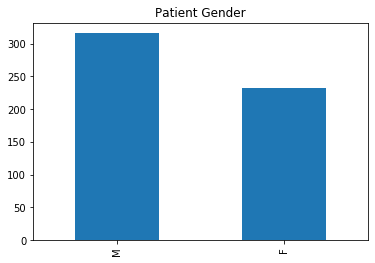

In [63]:
trainData['Patient Gender'].value_counts().plot(kind='bar',title='Patient Gender')

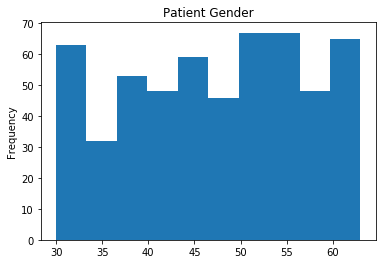

In [64]:
trainData['Patient Age'].plot(kind='hist',title='Patient Gender')

In [65]:
trainData['Pneumonia'].value_counts()

1    274
0    274
Name: Pneumonia, dtype: int64

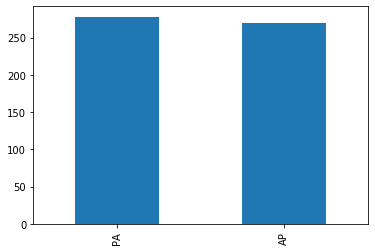

In [66]:
trainData['View Position'].value_counts().plot(kind='bar')

In [67]:
print ( "Width max & min:", trainData['OriginalImage[Width'].max(),trainData['OriginalImage[Width'].min() )
print ( "Height max & min", trainData['Height]'].max(),trainData['Height]'].min()  )

Width max & min: 3056 1857
Height max & min 3056 1797


**Demographic data look good, write the sampled training metadata to a csv file**

In [68]:
trainData.to_csv('Sampled_Pneumonia_Data.csv', index=False)